NameError: name 'np' is not defined

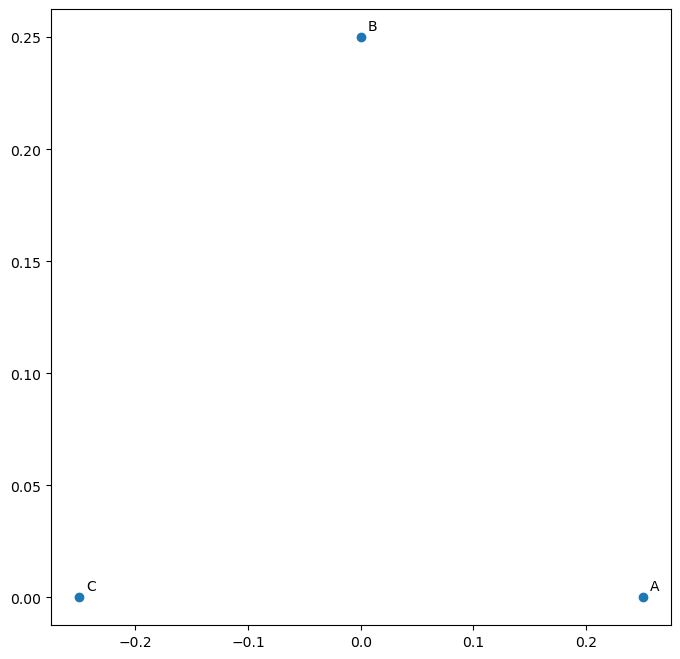

In [5]:
# File: uhg.py

import torch
import matplotlib.pyplot as plt
from matplotlib.patches import Arc

class UHGTensor:
    def __init__(self, data):
        if isinstance(data, (list, tuple)) and len(data) == 3:
            self.tensor = torch.tensor(data, dtype=torch.float32)
        elif isinstance(data, torch.Tensor) and data.shape == (3,):
            self.tensor = data
        else:
            raise ValueError(f"Expected 3 coordinates, got {data}")

    @classmethod
    def point(cls, x, y, z):
        return cls([float(x), float(y), float(z)])

    @classmethod
    def line(cls, l, m, n):
        return cls([float(l), float(m), float(n)])

    def is_null_point(self):
        return torch.isclose(self.tensor[0]**2 + self.tensor[1]**2 - self.tensor[2]**2, torch.tensor(0.0))

    def quadrance(self, other):
        return 1 - (self.tensor.dot(other.tensor)**2) / ((self.tensor**2).sum() * (other.tensor**2).sum())

    def join(self, other):
        return UHGTensor(torch.cross(self.tensor, other.tensor))

    def to_poincare_disk(self):
        return UHGTensor([self.tensor[0] / (1 + self.tensor[2]), self.tensor[1] / (1 + self.tensor[2]), 0.0])

    def __repr__(self):
        return f"UHGTensor({self.tensor.tolist()})"

def spread(L1, L2):
    dot_product = L1.tensor.dot(L2.tensor)
    norm_L1_squared = (L1.tensor**2).sum()
    norm_L2_squared = (L2.tensor**2).sum()
    return 1 - (dot_product**2) / (norm_L1_squared * norm_L2_squared)

def triple_quad_formula(a1, a2, a3):
    q1 = a2.quadrance(a3)
    q2 = a1.quadrance(a3)
    q3 = a1.quadrance(a2)
    lhs = (q1 + q2 + q3)**2
    rhs = 2 * (q1**2 + q2**2 + q3**2) + 4 * q1 * q2 * q3
    return torch.isclose(lhs, rhs)

def cross_law(a1, a2, a3):
    q1 = a2.quadrance(a3)
    q2 = a1.quadrance(a3)
    q3 = a1.quadrance(a2)
    L1 = a1.join(a2)
    L2 = a1.join(a3)
    S1 = spread(L1, L2)
    lhs = (q2 * q3 * S1 - q1 - q2 - q3 + 2)**2
    rhs = 4 * (1 - q1) * (1 - q2) * (1 - q3)
    return torch.isclose(lhs, rhs)

def to_poincare_disk(point):
    x, y, z = point.tensor
    return torch.tensor([x / (1 + z), y / (1 + z)])

def plot_poincare_disk(points, labels=None):
    fig, ax = plt.subplots(figsize=(8, 8))
    circle = plt.Circle((0, 0), 1, fill=False)
    ax.add_artist(circle)
    poincare_points = [to_poincare_disk(p) for p in points]
    x_coords = [p[0].item() for p in poincare_points]
    y_coords = [p[1].item() for p in poincare_points]
    ax.scatter(x_coords, y_coords)
    if labels:
        for i, (x, y) in enumerate(zip(x_coords, y_coords)):
            ax.annotate(labels[i], (x, y), xytext=(5, 5), textcoords='offset points')
    ax.set_xlim(-1.1, 1.1)
    ax.set_ylim(-1.1, 1.1)
    ax.set_aspect('equal')
    ax.set_title("Poincaré Disk Model")
    plt.grid(True)
    plt.show()

#Poincare Disk Lines

def geodesic_endpoints(p1, p2):
    """Calculate the endpoints of a geodesic line in the Poincaré disk model."""
    x1, y1 = p1
    x2, y2 = p2
    
    # If the points are on a straight line through the origin
    if abs(x1*y2 - x2*y1) < 1e-6:
        return np.array([x1, y1]), np.array([x2, y2])
    
    # Otherwise, calculate the circle parameters
    d = x1**2 + y1**2
    c = x2**2 + y2**2 - d
    a = 2*(x2*y1 - x1*y2)
    
    x0 = (c*y1 - (d-1)*y2) / a
    y0 = ((d-1)*x2 - c*x1) / a
    r = np.sqrt((x1-x0)**2 + (y1-y0)**2)
    
    # Calculate intersection points with the unit circle
    t = np.sqrt(x0**2 + y0**2 - 1)
    x_int1, x_int2 = (x0*(1-t**2) + 2*t*y0) / (1+t**2), (x0*(1-t**2) - 2*t*y0) / (1+t**2)
    y_int1, y_int2 = (y0*(1-t**2) - 2*t*x0) / (1+t**2), (y0*(1-t**2) + 2*t*x0) / (1+t**2)
    
    return np.array([x_int1, y_int1]), np.array([x_int2, y_int2])

def plot_poincare_disk(points, lines=None, labels=None):
    """Plot points and lines in the Poincaré disk model."""
    fig, ax = plt.subplots(figsize=(8, 8))
    
    # Draw the unit circle
    circle = plt.Circle((0, 0), 1, fill=False)
    ax.add_artist(circle)
    
    # Convert points to Poincaré disk coordinates and plot
    poincare_points = [to_poincare_disk(p) for p in points]
    x_coords = [p[0].item() for p in poincare_points]
    y_coords = [p[1].item() for p in poincare_points]
    ax.scatter(x_coords, y_coords)
    
    # Add labels if provided
    if labels:
        for i, (x, y) in enumerate(zip(x_coords, y_coords)):
            ax.annotate(labels[i], (x, y), xytext=(5, 5), textcoords='offset points')
    
    # Draw lines if provided
    if lines:
        for line in lines:
            p1, p2 = to_poincare_disk(line[0]), to_poincare_disk(line[1])
            start, end = geodesic_endpoints(p1, p2)
            
            # If it's a straight line
            if np.allclose(start, p1.numpy()) and np.allclose(end, p2.numpy()):
                ax.plot([start[0], end[0]], [start[1], end[1]], 'r-')
            else:
                center = (start + end) / 2
                radius = np.linalg.norm(start - center)
                angle = np.degrees(np.arctan2(end[1]-start[1], end[0]-start[0]))
                arc = Arc(center, 2*radius, 2*radius, angle=angle, 
                          theta1=0, theta2=180, color='r')
                ax.add_patch(arc)
    
    ax.set_xlim(-1.1, 1.1)
    ax.set_ylim(-1.1, 1.1)
    ax.set_aspect('equal')
    ax.set_title("Poincaré Disk Model")
    plt.grid(True)
    plt.show()

# Example usage (you can put this in a separate file)
if __name__ == "__main__":
    a = UHGTensor.point(0.5, 0.0, 1.0)
    b = UHGTensor.point(0.0, 0.5, 1.0)
    c = UHGTensor.point(-0.5, 0.0, 1.0)

    points = [a, b, c]
    lines = [(a, b), (b, c), (c, a)]
    labels = ['A', 'B', 'C']

    plot_poincare_disk(points, lines, labels)

# Hyperbolic Triangle Visualization

def hyperbolic_triangle_area(a, b, c):
    """Calculate the area of a hyperbolic triangle."""
    q1 = b.quadrance(c)
    q2 = a.quadrance(c)
    q3 = a.quadrance(b)
    
    S1 = spread(a.join(b), a.join(c))
    S2 = spread(b.join(a), b.join(c))
    S3 = spread(c.join(a), c.join(b))
    
    # Use the hyperbolic excess formula
    excess = S1 + S2 + S3 - np.pi
    return excess

def plot_hyperbolic_triangle(a, b, c):
    """Plot a hyperbolic triangle in the Poincaré disk model."""
    points = [a, b, c]
    lines = [(a, b), (b, c), (c, a)]
    labels = ['A', 'B', 'C']
    
    fig, ax = plt.subplots(figsize=(8, 8))
    
    # Draw the unit circle
    circle = plt.Circle((0, 0), 1, fill=False)
    ax.add_artist(circle)
    
    # Convert points to Poincaré disk coordinates and plot
    poincare_points = [to_poincare_disk(p) for p in points]
    x_coords = [p[0].item() for p in poincare_points]
    y_coords = [p[1].item() for p in poincare_points]
    ax.scatter(x_coords, y_coords)
    
    # Add labels
    for i, (x, y) in enumerate(zip(x_coords, y_coords)):
        ax.annotate(labels[i], (x, y), xytext=(5, 5), textcoords='offset points')
    
    # Draw lines
    for line in lines:
        p1, p2 = to_poincare_disk(line[0]), to_poincare_disk(line[1])
        start, end = geodesic_endpoints(p1, p2)
        
        if np.allclose(start, p1.numpy()) and np.allclose(end, p2.numpy()):
            ax.plot([start[0], end[0]], [start[1], end[1]], 'r-')
        else:
            center = (start + end) / 2
            radius = np.linalg.norm(start - center)
            angle = np.degrees(np.arctan2(end[1]-start[1], end[0]-start[0]))
            arc = Arc(center, 2*radius, 2*radius, angle=angle, 
                      theta1=0, theta2=180, color='r')
            ax.add_patch(arc)
    
    # Calculate and display the hyperbolic area
    area = hyperbolic_triangle_area(a, b, c)
    ax.text(0.05, 0.95, f'Hyperbolic Area: {area:.4f}', transform=ax.transAxes, 
            verticalalignment='top')
    
    ax.set_xlim(-1.1, 1.1)
    ax.set_ylim(-1.1, 1.1)
    ax.set_aspect('equal')
    ax.set_title("Hyperbolic Triangle in Poincaré Disk Model")
    plt.grid(True)
    plt.show()

# Example usage (you can put this in a separate file)
if __name__ == "__main__":
    a = UHGTensor.point(0.5, 0.0, 1.0)
    b = UHGTensor.point(0.0, 0.5, 1.0)
    c = UHGTensor.point(-0.3, -0.4, 1.0)

    plot_hyperbolic_triangle(a, b, c)

    # Compare with a triangle closer to the boundary
    d = UHGTensor.point(0.8, 0.0, 1.0)
    e = UHGTensor.point(0.0, 0.8, 1.0)
    f = UHGTensor.point(-0.7, -0.6, 1.0)

    plot_hyperbolic_triangle(d, e, f)

#Hyperbolic Transformations Animations
import torch
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np

def hyperbolic_rotation(point, angle):
    """Rotate a point in the Poincaré disk model."""
    x, y = point
    r = np.sqrt(x**2 + y**2)
    theta = np.arctan2(y, x)
    new_theta = theta + angle
    return r * np.cos(new_theta), r * np.sin(new_theta)

def hyperbolic_translation(point, direction, distance):
    """Translate a point in the Poincaré disk model."""
    x, y = point
    dx, dy = direction
    factor = np.tanh(distance) / np.sqrt(dx**2 + dy**2)
    a, b = dx * factor, dy * factor
    denominator = 1 + 2*(a*x + b*y) + (a**2 + b**2)*(x**2 + y**2)
    new_x = ((1 + a**2 + b**2)*x + (1 - x**2 - y**2)*(a + b*y)) / denominator
    new_y = ((1 + a**2 + b**2)*y + (1 - x**2 - y**2)*(b - a*x)) / denominator
    return new_x, new_y

def animate_hyperbolic_transformations(points):
    """Animate rotations and translations of points in the Poincaré disk model."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    
    # Setup for both subplots
    for ax in (ax1, ax2):
        circle = plt.Circle((0, 0), 1, fill=False)
        ax.add_artist(circle)
        ax.set_xlim(-1.1, 1.1)
        ax.set_ylim(-1.1, 1.1)
        ax.set_aspect('equal')
    
    ax1.set_title("Hyperbolic Rotation")
    ax2.set_title("Hyperbolic Translation")
    
    # Convert UHGTensor points to Poincaré disk coordinates
    poincare_points = [to_poincare_disk(p).numpy() for p in points]
    
    # Plot initial points
    scatter1 = ax1.scatter(*zip(*poincare_points))
    scatter2 = ax2.scatter(*zip(*poincare_points))
    
    def animate(frame):
        # Rotation
        angle = frame * 2 * np.pi / 100  # Full rotation over 100 frames
        rotated_points = [hyperbolic_rotation(p, angle) for p in poincare_points]
        scatter1.set_offsets(rotated_points)
        
        # Translation
        distance = frame * 0.02  # Move gradually
        direction = (1, 0)  # Move along x-axis
        translated_points = [hyperbolic_translation(p, direction, distance) for p in poincare_points]
        scatter2.set_offsets(translated_points)
        
        return scatter1, scatter2

    anim = FuncAnimation(fig, animate, frames=100, interval=50, blit=True)
    plt.close(fig)  # Prevent duplicate display in Jupyter
    return anim

# Example usage
if __name__ == "__main__":
    points = [
        UHGTensor.point(0.3, 0.2, 1.0),
        UHGTensor.point(-0.2, 0.4, 1.0),
        UHGTensor.point(0.1, -0.5, 1.0),
        UHGTensor.point(-0.4, -0.1, 1.0)
    ]
    
    anim = animate_hyperbolic_transformations(points)
    
    # To save the animation (optional)
    # anim.save('hyperbolic_transformations.gif', writer='pillow')
    
    # To display in Jupyter notebook
    from IPython.display import HTML
    HTML(anim.to_jshtml())